In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, GRU, concatenate, Input
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler

from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error

In [64]:
def get_metrics(y_true, y_pred):
    print(f'MAE: {mean_absolute_error(y_true, y_pred)}')
    print(f'medAE: {median_absolute_error(y_true, y_pred)}')
    print(f'MSE: {mean_squared_error(y_true, y_pred)}')
    print(f'MSLE: {mean_squared_log_error(y_true, y_pred)}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}')

In [65]:
df = pd.read_csv(open('powerconsumption.csv'))
df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [66]:
df.isna().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

In [67]:
df = df[::24 * 6].reset_index(drop = True)
msk = (df.index < len(df) - int(0.2 * len(df)))
df_train = df[msk].copy()
df_test = df[~msk].copy()

<Axes: >

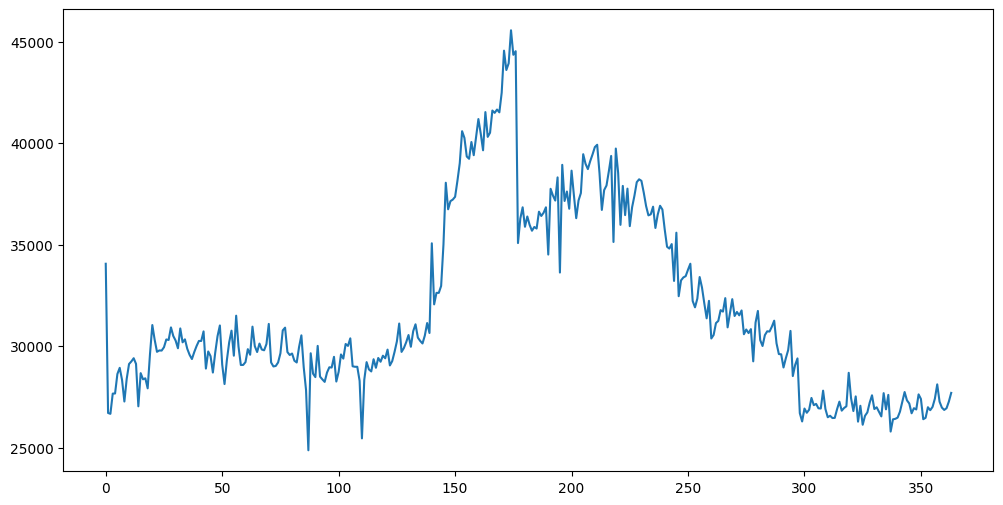

In [68]:
df['PowerConsumption_Zone1'].plot(figsize = (12, 6))

In [69]:
# df['PowerConsumption_Zone1'][::6 * 24].plot(figsize = (12, 6))

In [70]:
fh = ForecastingHorizon(df_test['PowerConsumption_Zone1'].index, is_relative = False)
fh

ForecastingHorizon([292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305,
       306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
       320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333,
       334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347,
       348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361,
       362, 363],
      dtype='int64', is_relative=False)

MAE: 1853.553838888888
medAE: 2001.8976249999996
MSE: 3803140.9419273864
MSLE: 0.004896128986135126
MAPE: 0.0687974544574993


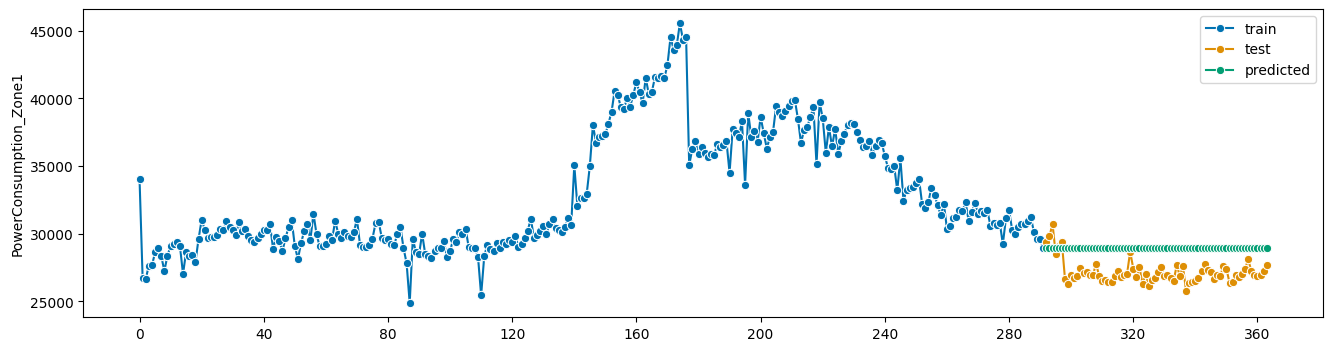

In [71]:
forecaster = NaiveForecaster(strategy = 'last')
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

MAE: 1853.553838888888
medAE: 2001.8976249999996
MSE: 3803140.9419273864
MSLE: 0.004896128986135126
MAPE: 0.0687974544574993


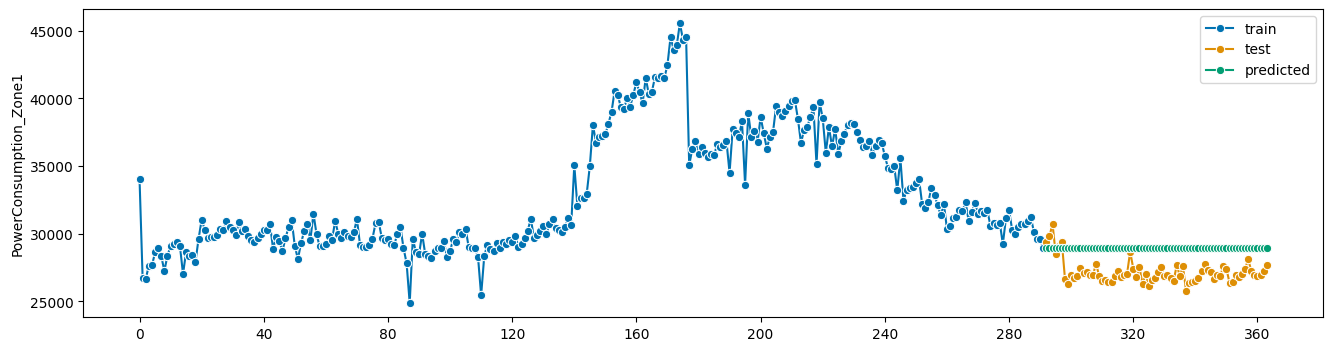

In [72]:
mapeforecaster = NaiveForecaster(strategy = 'mean')
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

MAE: 3834.3956077777775
medAE: 4107.30853
MSE: 16057961.782603264
MSLE: 0.01902370924649641
MAPE: 0.1420390354870546


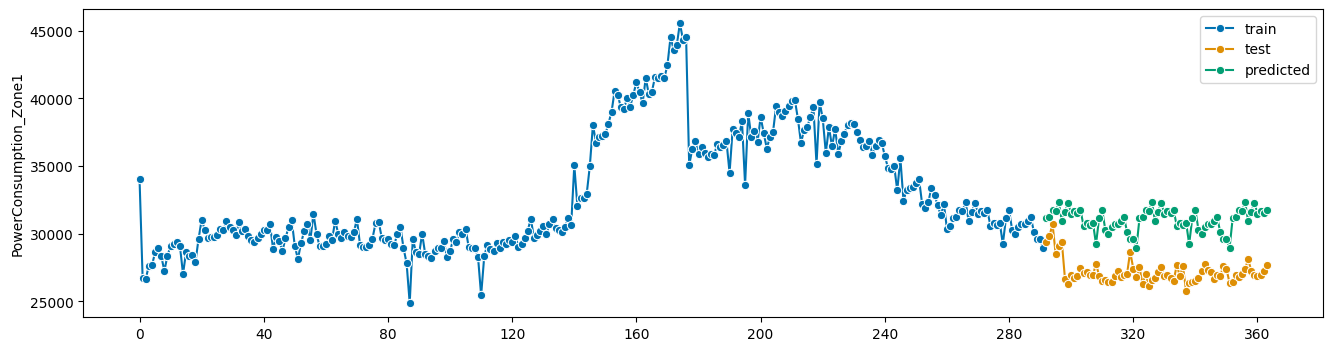

In [73]:
forecaster = NaiveForecaster(strategy = 'last', sp = 30)
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

MAE: 2176.9084833756456
medAE: 2369.610330672602
MSE: 5226191.459134744
MSLE: 0.0066431027175867545
MAPE: 0.08084181086071957


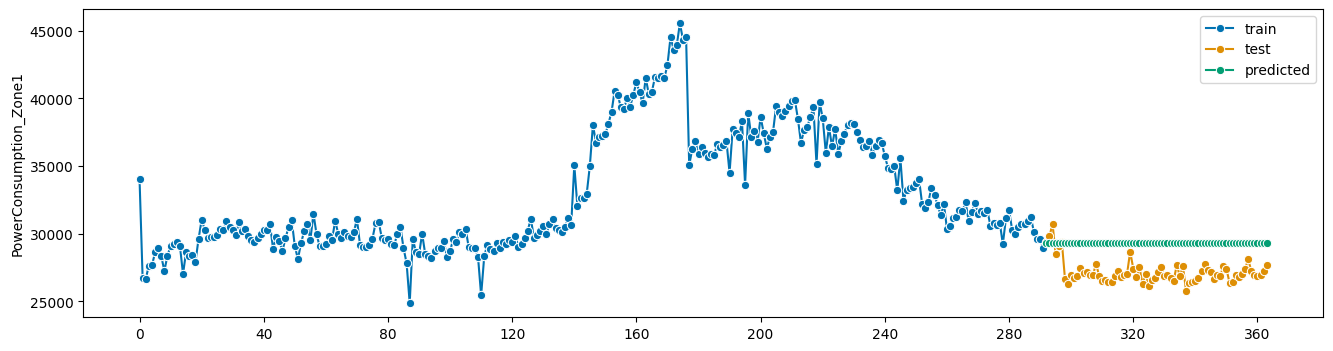

In [74]:
forecaster = ExponentialSmoothing()
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

/home/masikol/.local/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


MAE: 1409.3783698209782
medAE: 1181.2879790534698
MSE: 2983040.6160386205
MSLE: 0.00436195402509324
MAPE: 0.051834215957462515


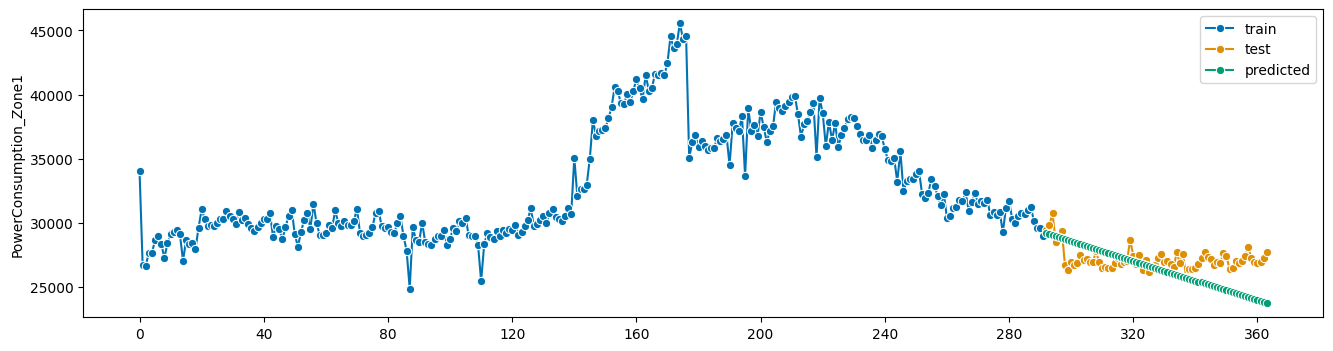

In [75]:
forecaster = ExponentialSmoothing(trend = 'add')
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

MAE: 2236.101931156331
medAE: 2436.202959425873
MSE: 5512826.891216652
MSLE: 0.006990927398588646
MAPE: 0.08304484944106866


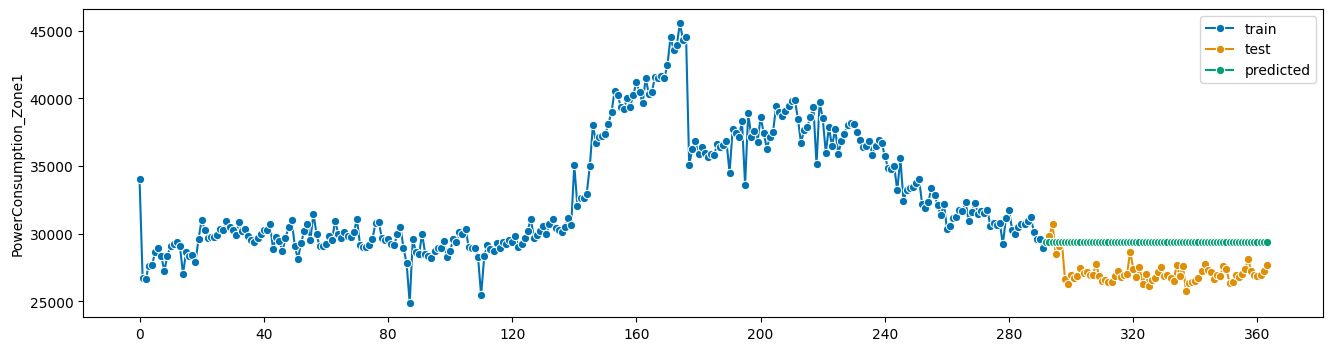

In [76]:
forecaster = AutoETS(auto = True, n_jobs = -1, information_criterion = 'bic', initial_trend = 'add')
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

In [77]:
forecaster.get_params()

{'additive_only': False,
 'allow_multiplicative_trend': False,
 'auto': True,
 'bounds': None,
 'callback': None,
 'damped_trend': False,
 'dates': None,
 'disp': False,
 'error': 'add',
 'freq': None,
 'full_output': True,
 'ignore_inf_ic': True,
 'information_criterion': 'bic',
 'initial_level': None,
 'initial_seasonal': None,
 'initial_trend': 'add',
 'initialization_method': 'estimated',
 'maxiter': 1000,
 'missing': 'none',
 'n_jobs': -1,
 'random_state': None,
 'restrict': True,
 'return_params': False,
 'seasonal': None,
 'sp': 1,
 'start_params': None,
 'trend': None}

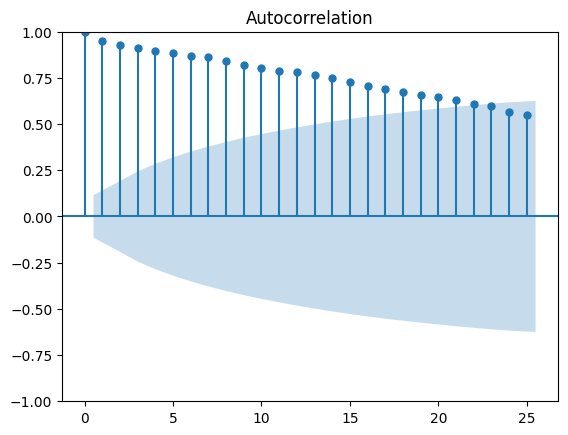

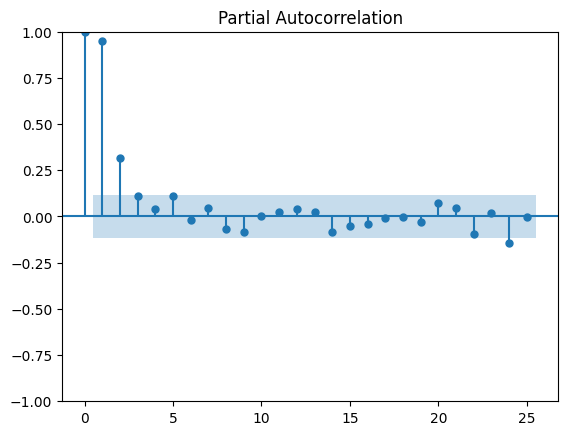

In [78]:
acf_original = plot_acf(df_train['PowerConsumption_Zone1'])
plt.show()

pacf_original = plot_pacf(df_train['PowerConsumption_Zone1'])
plt.show()

In [79]:
adf_test = adfuller(df_train['PowerConsumption_Zone1'])
print(f'p-value: {adf_test[1]}')

p-value: 0.41438681352069867


In [80]:
diff_data = df_train['PowerConsumption_Zone1'].diff()
diff_data = diff_data.dropna()
diff_data.isna().sum()

0

In [81]:
adf_test = adfuller(diff_data)
print(f'p-value: {adf_test[1]}')

p-value: 1.8456376504337972e-29


<Axes: >

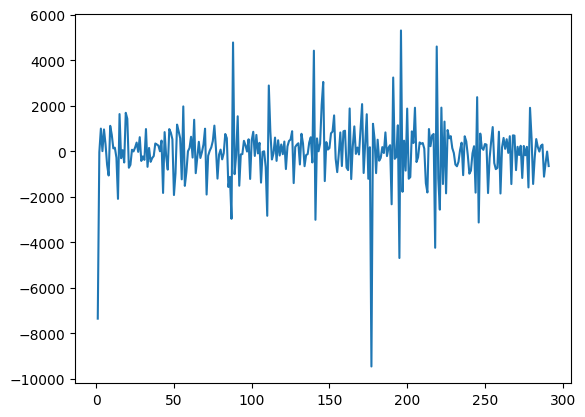

In [82]:
diff_data.plot()

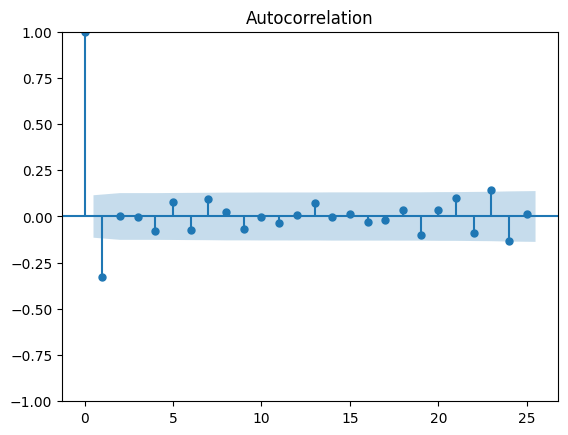

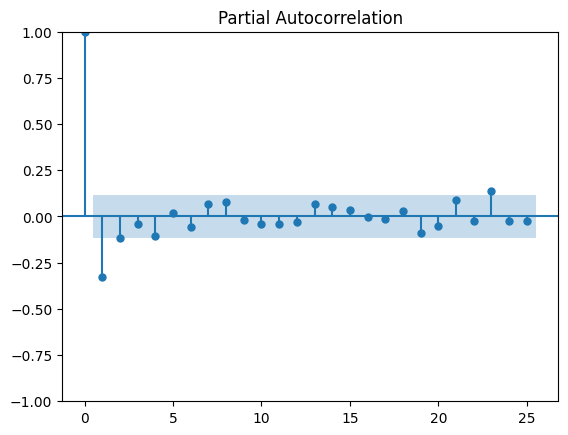

In [83]:
acf_original = plot_acf(diff_data)
plt.show()

pacf_original = plot_pacf(diff_data)
plt.show()

In [84]:
auto = auto_arima(df_train['PowerConsumption_Zone1'], seasonal = False, stepwise = False)
print(auto)
print(auto.summary())

 ARIMA(0,1,1)(0,0,0)[0] intercept
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2476.347
Date:                Wed, 03 Apr 2024   AIC                           4958.695
Time:                        19:01:59   BIC                           4969.715
Sample:                             0   HQIC                          4963.109
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.6840     47.174      0.205      0.837     -82.775     102.143
ma.L1         -0.4102      0.037    -11.003      0.000      -0.483      -0.337
sigma2      1.463e

In [85]:
auto = auto_arima(df_train['PowerConsumption_Zone1'], seasonal = True, stepwise = False)
print(auto)
print(auto.summary())

 ARIMA(0,1,1)(0,0,0)[1] intercept
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2476.347
Date:                Wed, 03 Apr 2024   AIC                           4958.695
Time:                        19:02:03   BIC                           4969.715
Sample:                             0   HQIC                          4963.109
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.6840     47.174      0.205      0.837     -82.775     102.143
ma.L1         -0.4102      0.037    -11.003      0.000      -0.483      -0.337
sigma2      1.463e

In [86]:
model = ARIMA(df_train['PowerConsumption_Zone1'], order = (0, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                                 SARIMAX Results                                  
Dep. Variable:     PowerConsumption_Zone1   No. Observations:                  292
Model:                     ARIMA(0, 1, 1)   Log Likelihood               -2476.371
Date:                    Wed, 03 Apr 2024   AIC                           4956.743
Time:                            19:02:03   BIC                           4964.089
Sample:                                 0   HQIC                          4959.686
                                    - 292                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4096      0.037    -11.129      0.000      -0.482      -0.337
sigma2      1.463e+06   4.35e+04     33.627      0.000    1.38e+06    1.55e+06
Ljung-Box (L1) (Q): 

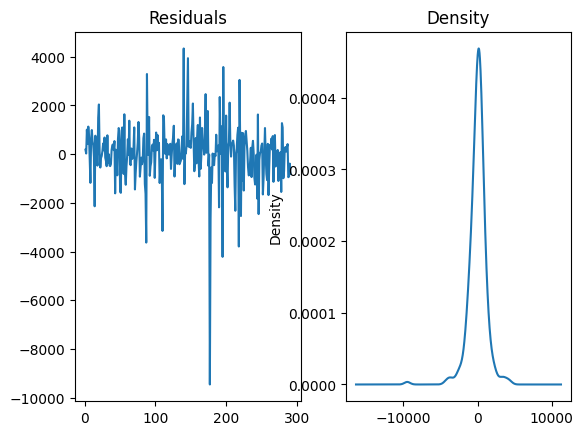

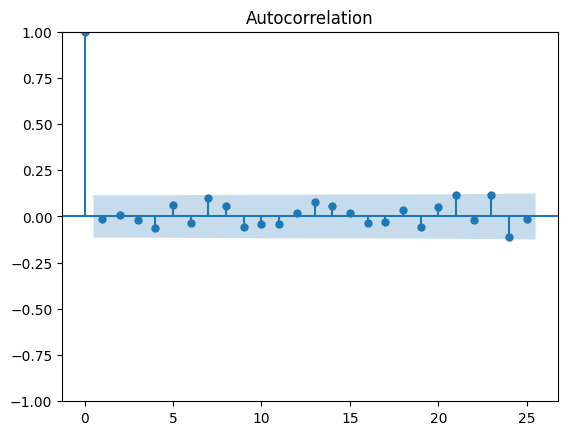

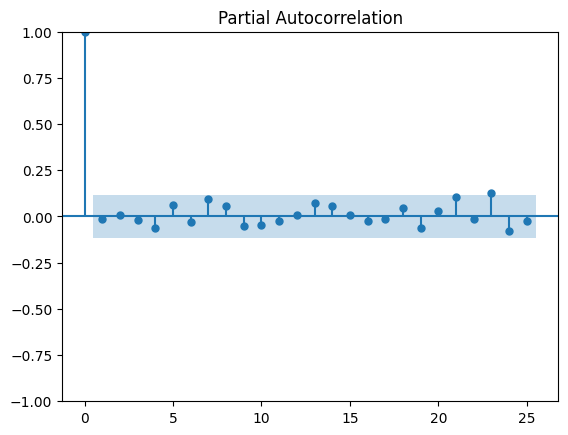

In [87]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(title = 'Density', kind = 'kde', ax = ax[1])
plt.show()

acf_original = plot_acf(residuals)
plt.show()

pacf_original = plot_pacf(residuals)
plt.show()

MAE: 2144.258137883078
medAE: 2332.878691993463
MSE: 5071882.3061114745
MSLE: 0.006455326083838457
MAPE: 0.0796266430764682


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='PowerConsumption_Zone1'>)

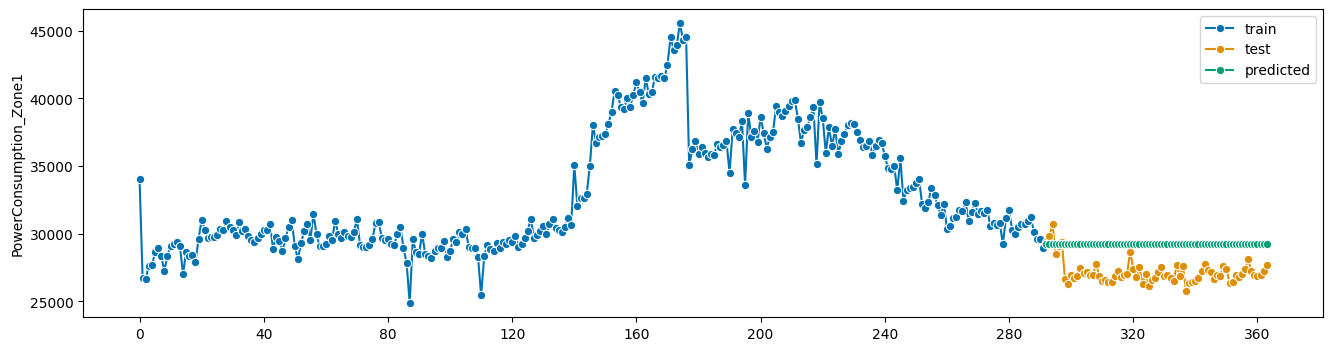

In [88]:
forecast = model_fit.forecast(steps = len(df_test['PowerConsumption_Zone1']))
predicted_values = forecast

get_metrics(df_test['PowerConsumption_Zone1'], forecast)
plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], predicted_values, labels = ['train', 'test', 'predicted'])

In [89]:
model = ARIMA(df_train['PowerConsumption_Zone1'], order = (0, 1, 1), seasonal_order = (0, 1, 1, 31))
model_fit = model.fit()
print(model_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:           PowerConsumption_Zone1   No. Observations:                  292
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 31)   Log Likelihood               -2279.628
Date:                          Wed, 03 Apr 2024   AIC                           4565.256
Time:                                  19:02:10   BIC                           4575.938
Sample:                                       0   HQIC                          4569.550
                                          - 292                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3847      0.045     -8.531      0.000      -0.473      -0.296
ma.S.L31      -0.6664      0.030    -22.315      0.

MAE: 1038.8277821034692
medAE: 961.867696095891
MSE: 1685025.8251256729
MSLE: 0.002185769891631939
MAPE: 0.038429340883873606


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='PowerConsumption_Zone1'>)

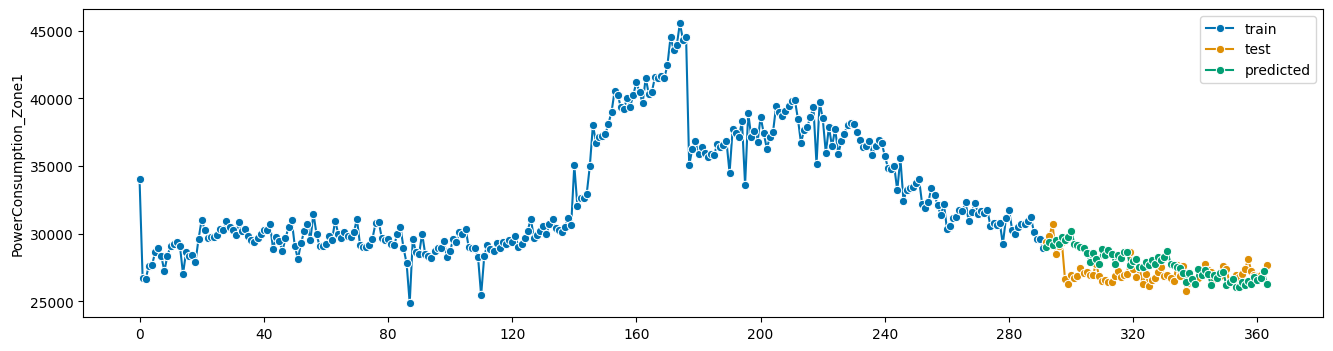

In [90]:
forecast = model_fit.forecast(steps = len(df_test['PowerConsumption_Zone1']))
predicted_values = forecast

get_metrics(df_test['PowerConsumption_Zone1'], forecast)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], predicted_values, labels = ['train', 'test', 'predicted'])

In [105]:
data = df['PowerConsumption_Zone1']
data = data.values.reshape(-1, 1)

time_steps = 60
n_neurons = 16

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

X, y = [], []
for i in range(len(data) - time_steps):
    X.append(data[i : (i + time_steps), 0])
    y.append(data[i + time_steps, 0])

X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(LSTM(units = n_neurons, return_sequences = True, input_shape = (time_steps, 1), activation = 'elu'))
model.add(LSTM(units = n_neurons, return_sequences = True, activation = 'elu'))
model.add(LSTM(units = n_neurons, return_sequences = True, activation = 'elu'))
model.add(LSTM(units = n_neurons, return_sequences = True, activation = 'elu'))
model.add(LSTM(units = n_neurons, return_sequences = False, activation = 'elu'))
model.add(Dense(units = 1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs = 20, batch_size = 8, validation_data = [X_test, y_test], callbacks = [early_stopping])

Epoch 1/20
31/31 [==============================] - 14s 108ms/step - loss: 0.0753 - mae: 0.2138 - val_loss: 0.0551 - val_mae: 0.2325
Epoch 2/20
31/31 [==============================] - 3s 93ms/step - loss: 0.0290 - mae: 0.1385 - val_loss: 0.0209 - val_mae: 0.1382
Epoch 3/20
31/31 [==============================] - 2s 67ms/step - loss: 0.0259 - mae: 0.1209 - val_loss: 0.0114 - val_mae: 0.0998
Epoch 4/20
31/31 [==============================] - 2s 65ms/step - loss: 0.0218 - mae: 0.1134 - val_loss: 0.0078 - val_mae: 0.0782
Epoch 5/20
31/31 [==============================] - 2s 77ms/step - loss: 0.0190 - mae: 0.1028 - val_loss: 0.0126 - val_mae: 0.1038
Epoch 6/20
31/31 [==============================] - 2s 67ms/step - loss: 0.0154 - mae: 0.0977 - val_loss: 0.0019 - val_mae: 0.0333
Epoch 7/20
31/31 [==============================] - 2s 68ms/step - loss: 0.0133 - mae: 0.0873 - val_loss: 0.0075 - val_mae: 0.0748
Epoch 8/20
31/31 [==============================] - 2s 64ms/step - loss: 0.0112 -

2/2 [==============================] - 1s 20ms/step
MAE: 0.030820130693863277
medAE: 0.024874324331971787
MSE: 0.001749016047420547
MSLE: 0.0013759755378503528
MAPE: 0.3047098913170396


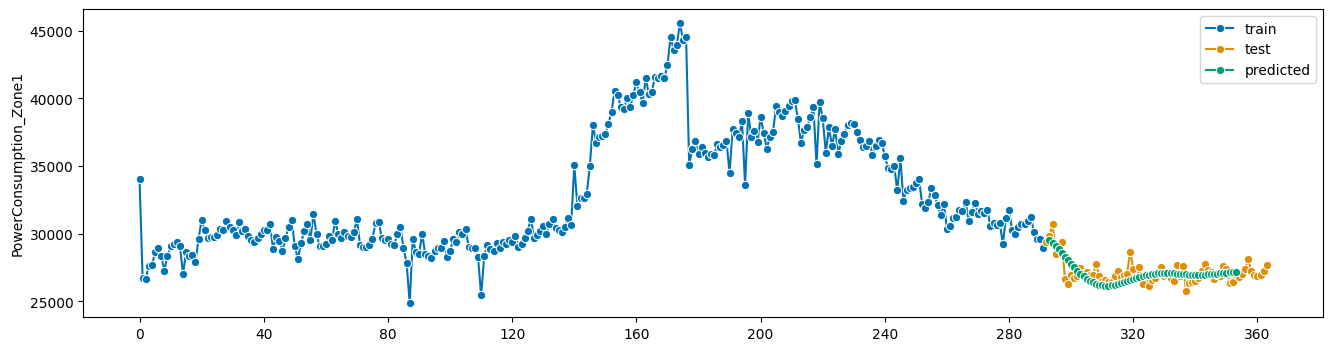

In [106]:
predicted_values = model.predict(X_test)

predicted_values_1d = scaler.inverse_transform(predicted_values).flatten()

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], 
            pd.Series(predicted_values_1d, index = range(split + time_steps - 10, len(predicted_values_1d) + split + time_steps - 10)), 
            labels = ['train', 'test', 'predicted'])

get_metrics(y_test, predicted_values)

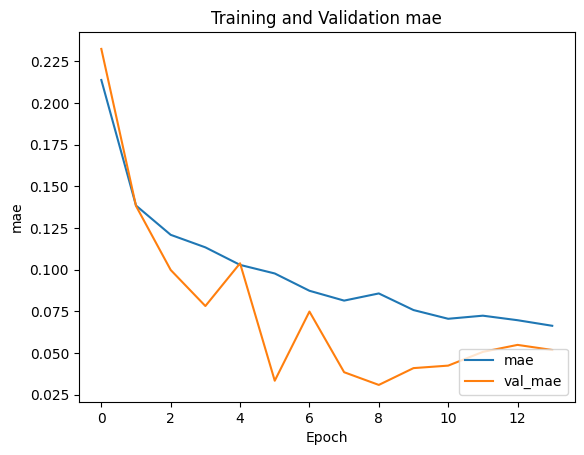

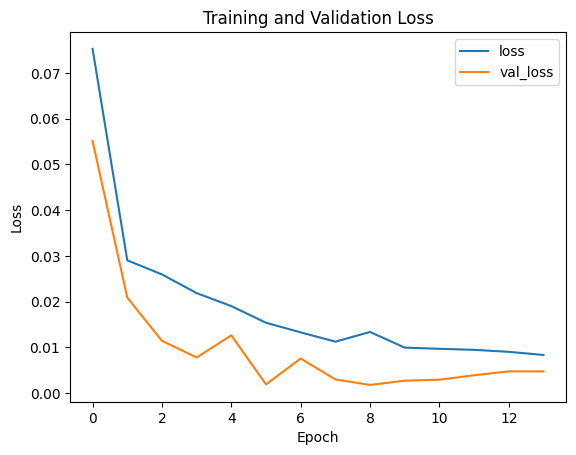

In [107]:
plt.plot(history.history['mae'], label = 'mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.legend(loc = 'upper right')
plt.title('Training and Validation mae')
plt.legend(loc = 'lower right')
plt.show()

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [108]:
data = df['PowerConsumption_Zone1']
data = data.values.reshape(-1, 1)

time_steps = 60
n_neurons = 16

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

X, y = [], []
for i in range(len(data) - time_steps):
    X.append(data[i : (i + time_steps), 0])
    y.append(data[i + time_steps, 0])

X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(GRU(units = n_neurons, return_sequences = True, input_shape = (time_steps, 1), activation = 'elu'))
model.add(GRU(units = n_neurons, return_sequences = True, activation = 'elu'))
model.add(GRU(units = n_neurons, return_sequences = True, activation = 'elu'))
model.add(GRU(units = n_neurons, return_sequences = True, activation = 'elu'))
model.add(GRU(units = n_neurons, return_sequences = False, activation = 'elu'))
model.add(Dense(units = 1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs = 20, batch_size = 8, validation_data = [X_test, y_test], callbacks = [early_stopping])

Epoch 1/20
31/31 [==============================] - 16s 161ms/step - loss: 0.0526 - mae: 0.1830 - val_loss: 0.0286 - val_mae: 0.1672
Epoch 2/20
31/31 [==============================] - 5s 161ms/step - loss: 0.0167 - mae: 0.1087 - val_loss: 0.0012 - val_mae: 0.0283
Epoch 3/20
31/31 [==============================] - 4s 116ms/step - loss: 0.0092 - mae: 0.0703 - val_loss: 0.0012 - val_mae: 0.0280
Epoch 4/20
31/31 [==============================] - 4s 125ms/step - loss: 0.0080 - mae: 0.0645 - val_loss: 0.0021 - val_mae: 0.0395
Epoch 5/20
31/31 [==============================] - 3s 101ms/step - loss: 0.0072 - mae: 0.0633 - val_loss: 9.2966e-04 - val_mae: 0.0234
Epoch 6/20
31/31 [==============================] - 4s 119ms/step - loss: 0.0067 - mae: 0.0598 - val_loss: 7.5572e-04 - val_mae: 0.0219
Epoch 7/20
31/31 [==============================] - 3s 100ms/step - loss: 0.0060 - mae: 0.0551 - val_loss: 7.7668e-04 - val_mae: 0.0217
Epoch 8/20
31/31 [==============================] - 2s 76ms/ste

2/2 [==============================] - 1s 23ms/step
MAE: 0.02187581495699971
medAE: 0.019883634486292934
MSE: 0.0007557209339766451
MSLE: 0.00061505907153105
MAPE: 0.230774111892974


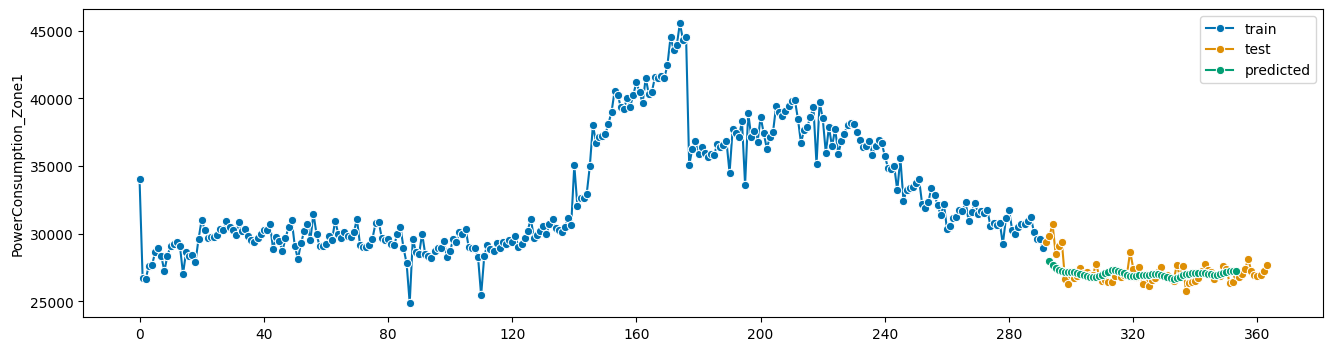

In [109]:
predicted_values = model.predict(X_test)

predicted_values_1d = scaler.inverse_transform(predicted_values).flatten()

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], 
            pd.Series(predicted_values_1d, index = range(split + time_steps - 10, len(predicted_values_1d) + split + time_steps - 10)), 
            labels = ['train', 'test', 'predicted'])

get_metrics(y_test, predicted_values)

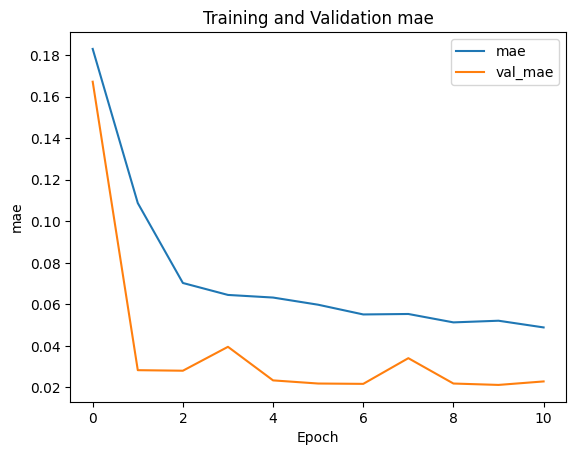

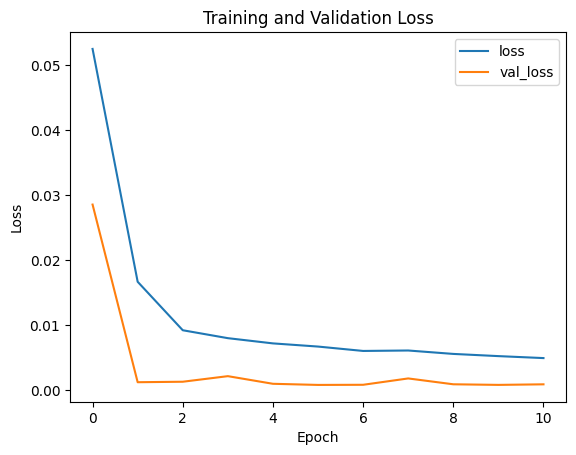

In [111]:
plt.plot(history.history['mae'], label = 'mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.legend(loc = 'upper right')
plt.title('Training and Validation mae')
plt.show()

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [177]:
data = df['PowerConsumption_Zone1']
data = data.values.reshape(-1, 1)

time_steps = 60
n_neurons = 16

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

X, y = [], []
for i in range(len(data) - time_steps):
    X.append(data[i : (i + time_steps), 0])
    y.append(data[i + time_steps, 0])


X, y = np.array(X), np.array(y)
X_rev = X[:, ::-1]

split = int(0.8 * len(X))
X_train_1, X_test_1 = X[:split], X[split:]
X_train_2, X_test_2 = X_rev[:split], X_rev[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

inp_1 = Input(shape = (time_steps, 1))
direct = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(inp_1)
direct = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(direct)
direct = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(direct)
direct = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(direct)
direct = GRU(units = n_neurons, return_sequences = False, activation = 'elu')(direct)

inp_2 = Input(shape = (time_steps, 1))
reverse = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(inp_2)
reverse = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(reverse)
reverse = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(reverse)
reverse = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(reverse)
reverse = GRU(units = n_neurons, return_sequences = False, activation = 'elu')(reverse)

concat = concatenate([direct, reverse])
concat = Dense(units = n_neurons * 8, activation = 'elu')(concat)
output = Dense(units = 1, activation = 'linear')(concat)

model = Model(inputs = [inp_1, inp_2], outputs = output)
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

history = model.fit([X_train_1, X_train_2], y_train, epochs = 20, batch_size = 8, 
                    validation_data = [[X_test_1, X_test_2], y_test], callbacks = [early_stopping])

Epoch 1/20
31/31 [==============================] - 22s 150ms/step - loss: 0.0455 - mae: 0.1666 - val_loss: 0.0324 - val_mae: 0.1778
Epoch 2/20
31/31 [==============================] - 3s 99ms/step - loss: 0.0132 - mae: 0.0873 - val_loss: 0.0016 - val_mae: 0.0323
Epoch 3/20
31/31 [==============================] - 3s 107ms/step - loss: 0.0089 - mae: 0.0698 - val_loss: 8.3768e-04 - val_mae: 0.0227
Epoch 4/20
31/31 [==============================] - 3s 111ms/step - loss: 0.0092 - mae: 0.0715 - val_loss: 0.0013 - val_mae: 0.0300
Epoch 5/20
31/31 [==============================] - 3s 113ms/step - loss: 0.0075 - mae: 0.0623 - val_loss: 0.0031 - val_mae: 0.0489
Epoch 6/20
31/31 [==============================] - 3s 103ms/step - loss: 0.0072 - mae: 0.0621 - val_loss: 0.0015 - val_mae: 0.0310
Epoch 7/20
31/31 [==============================] - 3s 106ms/step - loss: 0.0058 - mae: 0.0540 - val_loss: 0.0018 - val_mae: 0.0341
Epoch 8/20
31/31 [==============================] - 3s 113ms/step - loss

2/2 [==============================] - 2s 27ms/step
MAE: 0.02088188790002527
medAE: 0.015930593911970714
MSE: 0.0007229945318682455
MSLE: 0.0005889561753334647
MAPE: 0.218539382228214


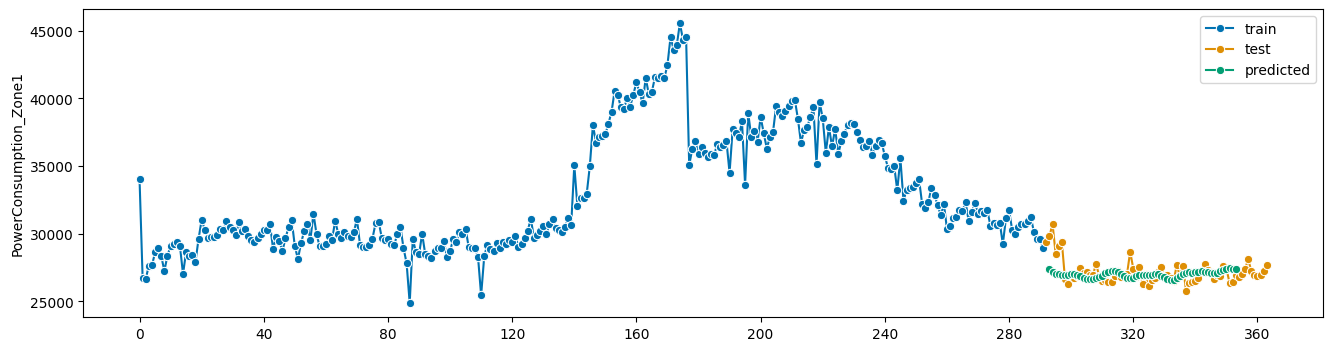

In [178]:
predicted_values = model.predict([X_test_1, X_test_2])

predicted_values_1d = scaler.inverse_transform(predicted_values).flatten()

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], 
            pd.Series(predicted_values_1d, index = range(split + time_steps - 10, len(predicted_values_1d) + split + time_steps - 10)), 
            labels = ['train', 'test', 'predicted'])

get_metrics(y_test, predicted_values)

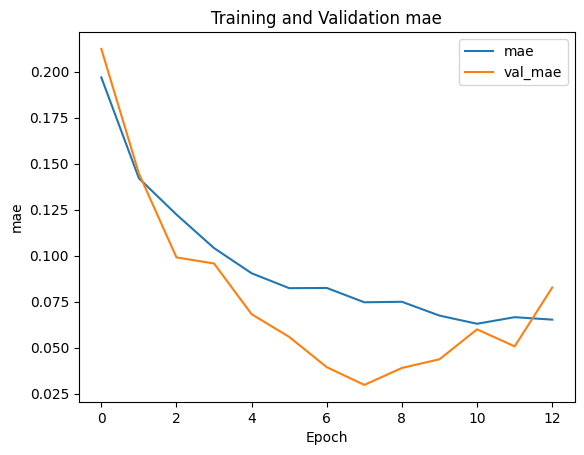

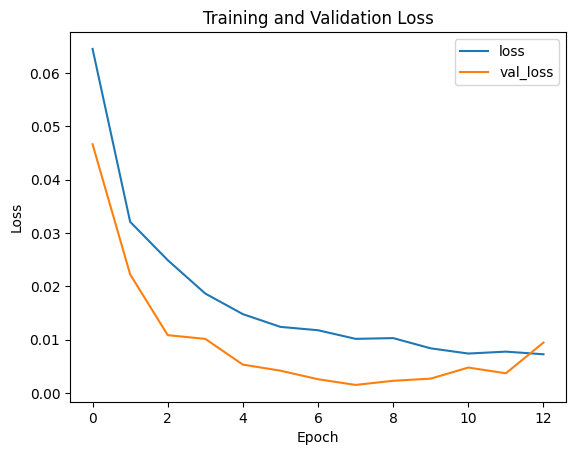

In [138]:
plt.plot(history.history['mae'], label = 'mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.legend(loc = 'upper right')
plt.title('Training and Validation mae')
plt.show()

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()